In [13]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import fsolve

LAMBDA = 1.73e-9 # Decay constant for tritium
N_burn = 9.3e-7 # Tritium burn rate in the plasma
TBR = 1.1

class Component:
    def __init__(self, name, residence_time, initial_inventory=0, tritium_source=0):
        self.name = name
        self.residence_time = residence_time
        self.input_ports = {}  # Dictionary where the key is the port name and the value is the port object
        self.output_ports = {}  # Dictionary where the key is the port name and the value is the port object
        self.tritium_inventory = initial_inventory
        self.tritium_source = tritium_source
        # self.equation = 0

    def add_input_port(self, port_name, incoming_fraction=1.0):
        if not (0 <= incoming_fraction <= 1):
            raise ValueError("Incoming fraction must be between 0 and 1")
        port = Port(port_name)
        port.incoming_fraction = incoming_fraction
        self.input_ports[port_name] = port
        return port

    def add_output_port(self, port_name):
        port = Port(port_name)
        self.output_ports[port_name] = port
        return port

    def __str__(self):
        return f"{self.name}: Residence Time = {self.residence_time}, Tritium Inventory = {self.tritium_inventory}"

    def add_tritium(self, amount):
        self.tritium_inventory += amount

    def remove_tritium(self, amount):
        if self.tritium_inventory >= amount:
            self.tritium_inventory -= amount
            return amount
        else:
            removed_amount = self.tritium_inventory
            self.tritium_inventory = 0
            return removed_amount
        
    def get_inflow(self):
        inflow = 0
        for port in self.input_ports.values():
            inflow += port.flow_rate
        return inflow   
        
    def get_outflow(self):
        return self.tritium_inventory / self.residence_time
    
    def calculate_inventory_derivative(self):
        inflow = self.get_inflow()
        outflow = self.get_outflow()
        decay = self.tritium_inventory * LAMBDA  # assuming decay_rate is a constant
        dydt = inflow - outflow - decay + self.tritium_source
        return dydt
    
    def update_inventory(self, new_value):
        self.tritium_inventory = new_value
    
class Plasma(Component):
    def __init__(self, name, N_burn, TBE, **kwargs):
        super().__init__(name, residence_time=1, **kwargs)
        self.N_burn = N_burn
        self.TBE = TBE

    # From fueling system
    def get_inflow(self):
        return self.N_burn / self.TBE

    # Exhaust
    def get_outflow(self):
        return (1 - self.TBE)/self.TBE * self.N_burn
    
    def calculate_inventory_derivative(self):
        return super().calculate_inventory_derivative() - self.N_burn


class FuelingSystem(Component):
    def __init__(self, name, N_burn, TBE, **kwargs):
        super().__init__(name, residence_time=1, **kwargs)
        self.N_burn = N_burn
        self.TBE = TBE

    # To plasma
    def get_outflow(self):
        return self.N_burn/self.TBE

class Port:
    def __init__(self, name, incoming_fraction=1.0):
        self.name = name
        self.flow_rate = 0
        self.incoming_fraction = incoming_fraction
        
    def set_flow_rate(self, flow_rate):
        self.flow_rate = flow_rate
    
class ComponentMap:
    def __init__(self):
        self.components = {}
        self.connections = {}

    def add_component(self, component):
        self.components[component.name] = component

    def connect_ports(self, component1, port1, component2, port2):
        if component1.name not in self.connections:
            self.connections[component1.name] = {}
        if component2.name not in self.connections:
            self.connections[component2.name] = {}

        self.connections[component1.name][port1.name] = (component2.name, port2.name)
        self.connections[component2.name][port2.name] = (component1.name, port1.name)
        if port1 and port2:
                port1.set_flow_rate(component1.get_outflow())
                port2.set_flow_rate(component1.get_outflow() * port2.incoming_fraction)

    def disconnect_ports(self, component1, port1, component2, port2):
        if component1.name in self.connections and port1.name in self.connections[component1.name]:
            del self.connections[component1.name][port1.name]
        if component2.name in self.connections and port2.name in self.connections[component2.name]:
            del self.connections[component2.name][port2.name]

    def get_connected_ports(self, component, port):
        if component.name in self.connections and port.name in self.connections[component.name]:
            connected_component_name, connected_port_name = self.connections[component.name][port.name]
            connected_component = self.components[connected_component_name]
            connected_port = connected_component.input_ports[connected_port_name]
            return connected_component, connected_port
        else:
            return None, None
        
    def update_flow_rates(self):
        for component_name, ports in self.connections.items():
            for port_name, (connected_component_name, connected_port_name) in ports.items():
                if port_name in self.components[component_name].output_ports:
                    component = self.components[component_name]
                    port = component.output_ports[port_name]
                    connected_component = self.components[connected_component_name]
                    connected_port = connected_component.input_ports[connected_port_name]
                    port.set_flow_rate(component.get_outflow())
                    connected_port.set_flow_rate(component.get_outflow() * connected_port.incoming_fraction)

    def print_connected_map(self):
        for component_name, ports in self.connections.items():
            print(f"Component: {component_name}")
            for port_name, (connected_component_name, connected_port_name) in ports.items():
                print(f"  Port: {port_name} -> Connected Component: {connected_component_name}, Connected Port: {connected_port_name}")

class Simulate:
    def __init__(self, dt, final_time, component_map):
        self.dt = dt
        self.final_time = final_time
        self.time = []
        self.n_steps = int(final_time / dt)
        self.initial_conditions = {name: component.tritium_inventory for name, component in component_map.components.items()}
        self.I_startup = component_map.components['Fueling System'].tritium_inventory
        self.y = np.zeros((self.n_steps + 1, len(self.initial_conditions)))
        self.components = component_map.components
        self.component_map = component_map

    def run(self):
        while True:
            self.y[0] = [component.tritium_inventory for component in self.components.values()] # self.initial_conditions, possibly updated by the restart method
            t,y = self.forward_euler()
            if self.components['Fueling System'].tritium_inventory < 0:
                print("Error: Tritium inventory in Fueling System is below zero.")
                self.update_I_startup()
                self.restart()
            else:
                return t,y
            
    def update_I_startup(self):
        self.I_startup += 0.1
        self.initial_conditions['Fueling System'] = self.I_startup

    def restart(self):
        self.time = []
        self.y = np.zeros((self.n_steps + 1, len(self.initial_conditions)))
        for component, initial_condition in zip(self.components.values(), self.initial_conditions.values()):
            component.tritium_inventory = initial_condition

    def forward_euler(self):
        print(self.y[0])
        for n in range(self.n_steps):
            t = n * self.dt
            if n % 1000 == 0:
                print(f"Percentage completed = {n/self.n_steps * 100:.1f}%", end='\r')
            dydt = self.f(self.y[n])
            self.y[n+1] = self.y[n] + self.dt * dydt
            self.time.append(t)
            for i, component in enumerate(self.components.values()):
                component.update_inventory(self.y[n+1][i])
            self.component_map.update_flow_rates()
        return [self.time, self.y[:-1,:]]

    def f(self, y):
        dydt = np.zeros_like(y)
        for i, component in enumerate(self.components.values()):
            dydt[i] += component.calculate_inventory_derivative()
        return dydt 
    
    

In [14]:
def visualize_connections(component_map):
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes for each component
    for component in component_map.components.values():
        G.add_node(component.name)

    # Add edges for each connection
    for component_name, ports in component_map.connections.items():
        for port_name, (connected_component_name, _) in ports.items():
            if port_name in component_map.components[component_name].output_ports:
                G.add_edge(component_name, connected_component_name)

    # Draw the graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, edge_color='gray', arrows=True)

    # Show the plot
    plt.show()


In [15]:
tau_ofc = 2 * 3600
tau_ifc = 4 * 3600
I_startup = 0.5 
TBE = 0.02
component1 = FuelingSystem("Fueling System", N_burn, TBE, initial_inventory=I_startup)
component2 = Component("OFC", tau_ofc, initial_inventory=0, tritium_source=N_burn * TBR)
component3 = Component("IFC", tau_ifc)
component4 = Plasma("Plasma", N_burn, TBE)
port1 = component1.add_output_port("Port 1")
port2 = component4.add_input_port("Port 2")
port3 = component4.add_output_port("Port 3")
port4 = component3.add_input_port("Port 4")
port5 = component3.add_output_port("Port 5")
port6 = component2.add_output_port("Port 6")
port7 = component1.add_input_port("Port 7")
port8 = component3.add_input_port("Port 8")

component_map = ComponentMap()
component_map.add_component(component1)
component_map.add_component(component2)
component_map.add_component(component3)
component_map.add_component(component4)
component_map.connect_ports(component1, port1, component4, port2)
component_map.connect_ports(component4, port3, component3, port4)
component_map.connect_ports(component3, port5, component1, port7)
component_map.connect_ports(component2, port6, component3, port8)
component_map.print_connected_map()
# visualize_connections(component_map)
component1.get_inflow()

Component: Fueling System
  Port: Port 1 -> Connected Component: Plasma, Connected Port: Port 2
  Port: Port 7 -> Connected Component: IFC, Connected Port: Port 5
Component: Plasma
  Port: Port 2 -> Connected Component: Fueling System, Connected Port: Port 1
  Port: Port 3 -> Connected Component: IFC, Connected Port: Port 4
Component: IFC
  Port: Port 4 -> Connected Component: Plasma, Connected Port: Port 3
  Port: Port 5 -> Connected Component: Fueling System, Connected Port: Port 7
  Port: Port 8 -> Connected Component: OFC, Connected Port: Port 6
Component: OFC
  Port: Port 6 -> Connected Component: IFC, Connected Port: Port 8


0.0

[0.5 0.  0.  0. ]
[ 7.35138258e-01  7.36550826e-03  6.70922302e-01 -4.23516469e-15]


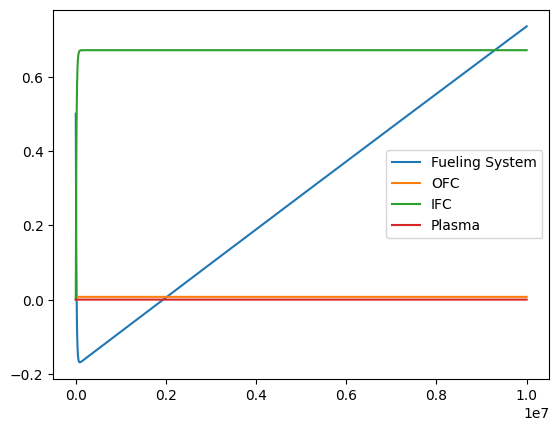

In [16]:
simulation = Simulate(0.1, 1e7, component_map)
t, y = simulation.run()
plt.plot(t, y)
plt.legend(component_map.components.keys())
print(y[-1,:])

Component: Fueling System
  Port: Fueling to Plasma -> Connected Component: Plasma, Connected Port: Port 2
  Port: Port 31 -> Connected Component: VP, Connected Port: VP to Fueling System
  Port: Port 12 -> Connected Component: Membrane, Connected Port: Membrane to fueling system
  Port: Port 7 -> Connected Component: ISS, Connected Port: ISS to fueling system
Component: Plasma
  Port: Port 2 -> Connected Component: Fueling System, Connected Port: Fueling to Plasma
  Port: Plasma to VP -> Connected Component: VP, Connected Port: Port 28
Component: VP
  Port: Port 28 -> Connected Component: Plasma, Connected Port: Plasma to VP
  Port: VP to fuel_cleanup -> Connected Component: Fuel cleanup, Connected Port: Port 4
  Port: VP to Fueling System -> Connected Component: Fueling System, Connected Port: Port 31
Component: Fuel cleanup
  Port: Port 4 -> Connected Component: VP, Connected Port: VP to fuel_cleanup
  Port: fuel_cleanup to ISS -> Connected Component: ISS, Connected Port: Port 32
Co

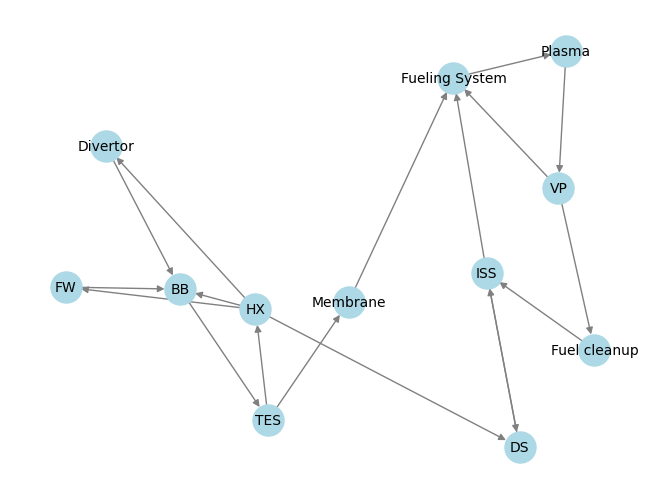

Startup inventory is: 1.1
Initial inventories = [1.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] kg
I_0 = 1.1 kg557.485767536, Error = 3.9745984281580604e-13, dt = 100, dt_new = 251597744.54583776
Doubling time: 2.029948550411198 

Startup inventory is: 1.1 

Error: Tritium inventory in Fueling System is below zero. Difference is -0.038610650964288507 kg
Updated I_startup to 1.1386106509642886
Initial inventories = [1.1386106509642886, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] kg
I_0 = 1.1386106509642886 kgrror = 3.9612757518625585e-13, dt = 100, dt_new = 252443925.3010367529.0235100511949
Doubling time: 2.089420197775123 

Startup inventory is: 1.1386106509642886 

Updated TBR at 1.061. Production is now 6.90711e-07
Initial inventories = [1.1386106509642886, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] kg
I_0 = 1.1386106509642886 kgError = 4.063416270128073e-13, dt = 100, dt_new = 246098340.293469748 699.0235030992922
Doubling time: 2.034410039019636 

Startup inventory is: 1.1386106509642886 

Updated TBR at 1.061

In [1]:

from fuelingSystem import FuelingSystem
from component import Component
from plasma import Plasma
from breedingBlanket import BreedingBlanket
from componentMap import ComponentMap
from matplotlib import pyplot as plt
from simulate import Simulate
from tools.utils import visualize_connections
import numpy as np

LAMBDA = 1.73e-9 # Decay constant for tritium
AF = 0.7
N_burn = 9.3e-7 * AF # Tritium burn rate in the plasma
TBR = 1.06
tau_bb = 1.25 * 3600
tau_fc =  3600
tau_tes = 24 * 3600
tau_HX = 1 * 3600
tau_FW = 1000
tau_div = 1000
tau_ds = 3600
tau_vp = 600
tau_iss = 3 * 3600
tau_membrane = 100

f_dir = 0.3
f_iss_ds = 0.1

I_startup = 1.1
TBE = 0.02
tes_efficiency = 0.9
final_time = 2.1 * 3600 * 24 * 365 # NB: longer than doubling time
hx_to_fw = 0.33
hx_to_div = 0.33
hx_to_ds = 1e-4
hx_to_BB = 1 - hx_to_fw - hx_to_div - hx_to_ds

q = 0.25
t_res = 24 * 3600
I_reserve = N_burn / TBE * q * t_res


# Define components
fueling_system = FuelingSystem("Fueling System", N_burn, TBE, initial_inventory=I_startup)
BB = BreedingBlanket("BB", tau_bb, initial_inventory=0, N_burn = N_burn, TBR = TBR)
FW = Component("FW", residence_time = tau_FW)
divertor = Component("Divertor", residence_time = tau_div)
fuel_cleanup = Component("Fuel cleanup", tau_fc)
plasma = Plasma("Plasma", N_burn, TBE) 
TES = Component("TES", residence_time = tau_tes)
HX = Component("HX", residence_time = tau_HX)
DS = Component("DS", residence_time = tau_ds)
VP = Component("VP", residence_time = tau_vp)
ISS = Component("ISS", residence_time = tau_iss)
membrane = Component("Membrane", residence_time = tau_membrane)

# Define ports
port1 = fueling_system.add_output_port("Fueling to Plasma")
port2 = plasma.add_input_port("Port 2")
port3 = plasma.add_output_port("Plasma to VP")
port4 = fuel_cleanup.add_input_port("Port 4", incoming_fraction= 1 - f_dir)
port5 = fuel_cleanup.add_output_port("fuel_cleanup to ISS")
port6 = BB.add_output_port("OFC to TES")
port7 = fueling_system.add_input_port("Port 7", incoming_fraction=1 - f_iss_ds)
port8 = fuel_cleanup.add_input_port("Port 8")
port9 = TES.add_output_port("TES to Fueling System")
port10 = TES.add_output_port("TES to HX")
port11 = TES.add_input_port("Port 11")
port12 = fueling_system.add_input_port("Port 12")
port13 = HX.add_input_port("Port 13", incoming_fraction=1-tes_efficiency)
port14 = HX.add_output_port("HX to BB")
port15 = BB.add_input_port("Port 15", incoming_fraction= hx_to_BB)
port16 = FW.add_input_port("Port 16", incoming_fraction=hx_to_fw)
port17 = FW.add_output_port("FW to BB")
port18 = divertor.add_input_port("Port 18", incoming_fraction=hx_to_div)
port19 = divertor.add_output_port("Divertor to FW")
port20 = HX.add_output_port("HX to FW")
port21 = HX.add_output_port("HX to div")
port22 = BB.add_input_port("Port 22")
port23 = BB.add_input_port("Port 23")
port24 = DS.add_input_port("Port 24", incoming_fraction=hx_to_ds)
port25 = DS.add_output_port("DS to fuel cleanup")
port26 = HX.add_output_port("HX to DS")
port27 = fuel_cleanup.add_input_port("Port 27")  
port28 = VP.add_input_port("Port 28")
port29 = VP.add_output_port("VP to fuel_cleanup")
port30 = VP.add_output_port("VP to Fueling System")
port31 = fueling_system.add_input_port("Port 31", incoming_fraction=f_dir)
port32 = ISS.add_input_port("Port 32")
port33 = ISS.add_input_port("Port 33")
port34 = ISS.add_output_port("ISS to fueling system")
port35 = DS.add_input_port("Port 35", incoming_fraction=f_iss_ds)
port36 = ISS.add_output_port("ISS to DS")
port37 = membrane.add_input_port("Port 37", incoming_fraction=tes_efficiency)
port38 = membrane.add_output_port("Membrane to fueling system")

# Add components to component map
component_map = ComponentMap()
component_map.add_component(fueling_system)
component_map.add_component(BB)
component_map.add_component(fuel_cleanup)
component_map.add_component(plasma)
component_map.add_component(TES)
component_map.add_component(HX)
component_map.add_component(FW)
component_map.add_component(divertor)
component_map.add_component(DS)
component_map.add_component(VP)
component_map.add_component(ISS)
component_map.add_component(membrane)

# Connect ports
component_map.connect_ports(fueling_system, port1, plasma, port2)
component_map.connect_ports(plasma, port3, VP, port28)
component_map.connect_ports(VP, port29, fuel_cleanup, port4)
component_map.connect_ports(VP, port30, fueling_system, port31)
component_map.connect_ports(fuel_cleanup, port5, ISS, port32)
component_map.connect_ports(BB, port6, TES, port11)
component_map.connect_ports(TES, port9, membrane, port37)
component_map.connect_ports(membrane, port38, fueling_system, port12)
component_map.connect_ports(TES, port10, HX, port13)
component_map.connect_ports(HX, port14, BB, port15)
component_map.connect_ports(HX, port20, FW, port16)
component_map.connect_ports(HX, port21, divertor, port18)
component_map.connect_ports(FW, port17, BB, port22)
component_map.connect_ports(divertor, port19, BB, port23)
component_map.connect_ports(HX, port26, DS, port24)
component_map.connect_ports(DS, port25, ISS, port33)
component_map.connect_ports(ISS, port34, fueling_system, port7)
component_map.connect_ports(ISS, port36, DS, port35)

component_map.print_connected_map()
visualize_connections(component_map)
print(f'Startup inventory is: {fueling_system.tritium_inventory}')
simulation = Simulate(dt=0.01, final_time=final_time, I_reserve=I_reserve, component_map=component_map)
t, y = simulation.run()

In [9]:
for component in component_map.components.values():
    print(f'{component.name} inventory: {component.tritium_inventory * 1e3:.3f} g')

for component in component_map.components.values():
# print component flows
    print(f'{component.name} inflow: {component.get_inflow() * 1e6:.3f} g/s')
    print(f'{component.name} outflow: {component.get_outflow() * 1e6:.3f} g/s')



4.557e-05

/Users/meschini/Library/Python/3.12/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/meschini/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


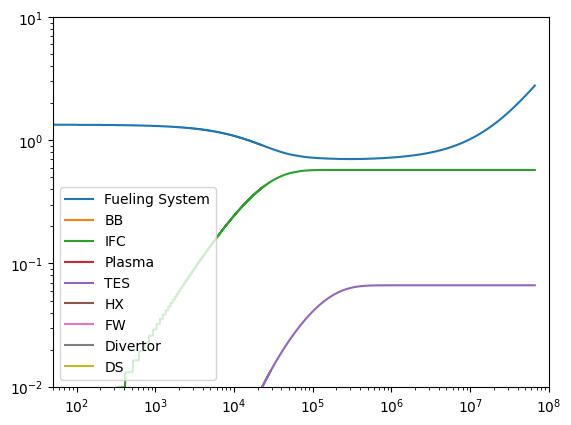

In [24]:
plt.loglog(t, y)
plt.xlim(50, 1e8)
plt.ylim(1e-2, 10)
plt.legend(component_map.components.keys())

Component: Fueling System
  Port: Fueling to Plasma -> Connected Component: Plasma, Connected Port: Port 2
  Port: Port 7 -> Connected Component: IFC, Connected Port: IFC to Fueling System
  Port: Port 12 -> Connected Component: TES, Connected Port: TES to Fueling System
Component: Plasma
  Port: Port 2 -> Connected Component: Fueling System, Connected Port: Fueling to Plasma
  Port: Plasma to IFC -> Connected Component: IFC, Connected Port: Port 4
Component: IFC
  Port: Port 4 -> Connected Component: Plasma, Connected Port: Plasma to IFC
  Port: IFC to Fueling System -> Connected Component: Fueling System, Connected Port: Port 7
Component: BB
  Port: OFC to TES -> Connected Component: TES, Connected Port: Port 11
  Port: Port 15 -> Connected Component: HX, Connected Port: Port 14
Component: TES
  Port: Port 11 -> Connected Component: BB, Connected Port: OFC to TES
  Port: TES to Fueling System -> Connected Component: Fueling System, Connected Port: Port 12
  Port: TES to HX -> Connect

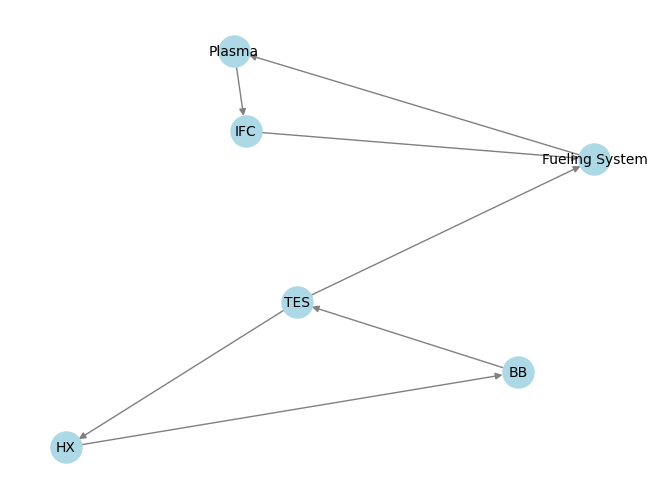

[0.1, 0, 0, 0, 0, 0]
I = [0.1        0.09999535 0.09534489 ... 4.39059124 4.39059867 4.39060611] kg037284.080918544
I_0 = 0.1 kg
Doubling time: 0 

Startup inventory is: 4.390606106207411 

Startup inventory is: [0.1, 0, 0, 0, 0, 0] 

Component inventories [4.39059867e+00 8.18265426e-03 8.20152445e-01 6.15896763e+01
 9.81673611e-02 4.08987226e-04]


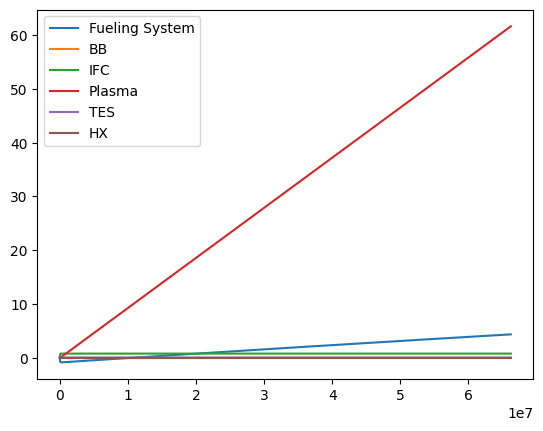

In [ ]:

from fuelingSystem import FuelingSystem
from component import Component
from plasma import Plasma
from breedingBlanket import BreedingBlanket
from componentMap import ComponentMap
from matplotlib import pyplot as plt
from simulate import Simulate
import numpy as np
from tools.utils import visualize_connections

LAMBDA = 1.73e-9 # Decay constant for tritium
N_burn = 9.3e-7 # Tritium burn rate in the plasma
TBR = 1.1
tau_ofc = 2 * 3600
tau_ifc = 5 * 3600
tau_tes = 24 * 3600
tau_HX = 1 * 3600
I_startup = 0.9
TBE = 0.02
tes_efficiency = 0.9
final_time = 2.1 * 3600 * 24 * 365 # NB: longer than doubling time

# Define components
fueling_system = FuelingSystem("Fueling System", N_burn, TBE, initial_inventory=I_startup)
BB = BreedingBlanket("BB", tau_ofc, initial_inventory=0, N_burn = N_burn, TBR = TBR)
IFC = Component("IFC", tau_ifc)
plasma = Plasma("Plasma", N_burn, TBE) 
TES = Component("TES", residence_time = tau_tes)
HX = Component("HX", residence_time = tau_HX)

# Define ports
port1 = fueling_system.add_output_port("Fueling to Plasma")
port2 = plasma.add_input_port("Port 2")
port3 = plasma.add_output_port("Plasma to IFC")
port4 = IFC.add_input_port("Port 4")
port5 = IFC.add_output_port("IFC to Fueling System")
port6 = BB.add_output_port("OFC to TES")
port7 = fueling_system.add_input_port("Port 7")
port8 = IFC.add_input_port("Port 8")
port9 = TES.add_output_port("TES to Fueling System")
port10 = TES.add_output_port("TES to HX")
port11 = TES.add_input_port("Port 11")
port12 = fueling_system.add_input_port("Port 12", incoming_fraction=tes_efficiency)
port13 = HX.add_input_port("Port 13", incoming_fraction=1-tes_efficiency)
port14 = HX.add_output_port("Port 14")
port15 = BB.add_input_port("Port 15")

# Add components to component map
component_map = ComponentMap()
component_map.add_component(fueling_system)
component_map.add_component(BB)
component_map.add_component(IFC)
component_map.add_component(plasma)
component_map.add_component(TES)
component_map.add_component(HX)

# Connect ports
component_map.connect_ports(fueling_system, port1, plasma, port2)
component_map.connect_ports(plasma, port3, IFC, port4)
component_map.connect_ports(IFC, port5, fueling_system, port7)
component_map.connect_ports(BB, port6, TES, port11)
component_map.connect_ports(TES, port9, fueling_system, port12)
component_map.connect_ports(TES, port10, HX, port13)
component_map.connect_ports(HX, port14, BB, port15)

component_map.print_connected_map()
visualize_connections(component_map)

simulation = Simulate(0.1, final_time, component_map)
t, y = simulation.run()
plt.figure()
plt.plot(t, y)
plt.legend(component_map.components.keys())
print(f"Component inventories {y[-1]}")

In [ ]:
# print outflows of each component
for component in component_map.components.values():
    print(f"Outflow of {component.name} = {component.get_outflow()}")

# print inflows of each component
for component in component_map.components.values():
    print(f"Inflow of {component.name} = {component.get_inflow()}")

Outflow of Fueling System = 4.65e-05
Outflow of BB = 1.0874346789816275e-06
Outflow of IFC = 4.539105053944063e-05
Outflow of Plasma = 4.557e-05
Outflow of TES = 6.98754952137935e-07
Outflow of HX = 6.818746213257724e-08
Inflow of Fueling System = 4.601992999636477e-05
Inflow of BB = 6.818746213257724e-08
Inflow of IFC = 4.557e-05
Inflow of Plasma = 4.65e-05
Inflow of TES = 1.0874346789816275e-06
Inflow of HX = 6.987549521379349e-08


In [15]:
class Component:
    """
    Represents a component in a fuel cycle system.
    """

    def __init__(self, name, residence_time, initial_inventory=0, tritium_source=0, non_radioactive_loss=1e-4):
        """
        Initializes a Component object.

        Args:
            name (str): The name of the component.
            residence_time (float): The residence time of the component in seconds.
            initial_inventory (float, optional): The initial tritium inventory of the component. Defaults to 0.
            tritium_source (float, optional): The tritium source rate for the component. Defaults to 0.
            non_radioactive_loss (float, optional): The non-radioactive loss rate for the component. Defaults to 1e-4.
        """
        self.name = name
        self.residence_time = residence_time
        self.input_ports = {}  # Dictionary where the key is the port name and the value is the port object
        self.output_ports = {}  # Dictionary where the key is the port name and the value is the port object
        self.tritium_inventory = initial_inventory
        self.tritium_source = tritium_source
        self.non_radioactive_loss = non_radioactive_loss

class PulsedSource:
    def __init__(self, amplitude, pulse_duration, pulse_period):
        """
        Initializes a PulsedSource object.

        Parameters:
        amplitude (float): The amplitude of the pulse.
        pulse_duration (float): The duration of each pulse.
        pulse_period (float): The period between pulses.
        """
        self.amplitude = amplitude
        self.pulse_duration = pulse_duration
        self.pulse_period = pulse_period

class Plasma(Component, PulsedSource):
    def __init__(self, name, N_burn, TBE, AF, pulse_period, *args, **kwargs):
        """
        Initialize a Plasma object.

        Args:
            name (str): The name of the plasma.
            N_burn (float): The burn rate of the plasma.
            TBE (float): The tritium burnup efficiency of the plasma.
            AF (float): The amplification factor of the pulse.
            pulse_period (float): The period between pulses.
            residence_time (float): The residence time of the component.
            initial_inventory (float, optional): The initial tritium inventory of the component. Defaults to 0.
            tritium_source (float, optional): The tritium source rate for the component. Defaults to 0.
            non_radioactive_loss (float, optional): The non-radioactive loss rate for the component. Defaults to 1e-4.
        """
        Component.__init__(self, name, residence_time = 1, *args, **kwargs)
        PulsedSource.__init__(self, amplitude=N_burn, pulse_duration=pulse_period*AF, pulse_period=pulse_period)

# Example usage
N_burn = 1.0
TBE = 0.5
AF = 0.2
pulse_period = 10.0
residence_time = 5.0

plasma = Plasma("Plasma", N_burn, TBE, AF, pulse_period)
